In [11]:
# basic packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [80]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=['MedHouseVal'])

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [13]:
X.shape

(20640, 8)

In [81]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (common preprocessing step)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PyTorch Setup for Regression (Price Prediction)

## **Pytorch test loss:  0.2533**

* batch_size = 64
* Architecture:         
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

* activation = tanh
* learning_rate = 0.001
* epochs = 50




In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim


In [16]:
# Convert data to PyTorch tensors (backend setup)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


In [17]:
# Create the model
class RegressionNN(nn.Module):
    def __init__(self, input_size=8):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1) # 1 output for house value prediction

    def forward(self, x):
      # functional API
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x


In [18]:
# Initialize the model, loss function, and optimizer
pytorch_model = RegressionNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)


In [19]:
!pip install torchsummary

In [20]:
from torchsummary import summary
print("PyTorch Model Summary:")
summary(pytorch_model, input_size=(8,))

PyTorch Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,152
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                    [-1, 1]              33
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [21]:
def train_regression(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward() # backpropagation
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


train_regression(train_loader, pytorch_model, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.8599338576544163
Epoch 2/10, Loss: 0.4263979973372563
Epoch 3/10, Loss: 0.38287146597407584
Epoch 4/10, Loss: 0.36072703658841376
Epoch 5/10, Loss: 0.34638784877782647
Epoch 6/10, Loss: 0.3352428339132967
Epoch 7/10, Loss: 0.3257586768315744
Epoch 8/10, Loss: 0.31966408677110375
Epoch 9/10, Loss: 0.3170776819131633
Epoch 10/10, Loss: 0.31068805345269135


In [22]:
def eval_regression(test_loader, model):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

test_loss = eval_regression(test_loader, pytorch_model)
print(f"Test Loss: {test_loss}")

Test Loss: 0.31333038738140695


In [23]:
# Get a batch of data from the training set in PyTorch
data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)


# Forward pass through the model to get predictions (continuous values for regression)
outputs = pytorch_model(X_batch)

# Print the predicted values and actual values for the batch (regression outputs)
print(f'Predicted values (PyTorch): {outputs.squeeze().detach().numpy()}')  # Squeeze and convert to numpy for readability
print(f'Actual values (PyTorch): {y_batch.squeeze().detach().numpy()}')  # Squeeze and convert to numpy for readability

# Calculate the Mean Squared Error (MSE) for this batch
mse_loss = nn.MSELoss()
loss = mse_loss(outputs, y_batch)
print(f'Mean Squared Error for this batch (PyTorch): {loss.item()}')


Predicted values (PyTorch): [1.1088295  0.84051496 3.8895936  2.7850163  1.658915   2.3016274
 1.0529544  3.8609264  4.841531   1.1755544  0.6684891  2.8636742
 2.9372616  2.995438   0.9807161  2.905274   0.7918652  0.8587705
 1.6073065  1.9147376  2.0824952  1.2681947  2.098209   2.615275
 3.791615   0.7804477  3.2224479  0.769968   0.7456026  0.7607118
 1.3140193  1.544944   2.0378196  1.6322602  3.0230722  1.112746
 2.292899   4.6399817  0.8450835  2.4085717  1.4173554  4.89384
 1.5634086  1.2966509  1.0088897  1.3191066  1.0087738  2.1183121
 2.7715464  0.51106143 1.9022121  4.1041665  1.4948905  1.9143329
 1.165442   1.0201902  2.4703517  1.0381452  2.6416764  3.3157215
 1.3181617  2.704564   2.1705852  1.805949  ]
Actual values (PyTorch): [1.156   0.685   3.762   1.269   1.688   4.508   1.486   4.175   5.00001
 0.602   0.696   3.179   4.646   3.019   1.567   3.889   0.342   0.927
 2.296   5.00001 1.557   0.972   1.524   2.728   2.365   0.723   1.125
 0.944   0.858   0.743   1.911

Epoch [1/50], Train Loss: 0.3079, Test Loss: 0.3268
Epoch [2/50], Train Loss: 0.3027, Test Loss: 0.3058
Epoch [3/50], Train Loss: 0.2977, Test Loss: 0.3039
Epoch [4/50], Train Loss: 0.2929, Test Loss: 0.3155
Epoch [5/50], Train Loss: 0.2924, Test Loss: 0.2975
Epoch [6/50], Train Loss: 0.2884, Test Loss: 0.3025
Epoch [7/50], Train Loss: 0.2856, Test Loss: 0.2971
Epoch [8/50], Train Loss: 0.2806, Test Loss: 0.2923
Epoch [9/50], Train Loss: 0.2771, Test Loss: 0.2932
Epoch [10/50], Train Loss: 0.2769, Test Loss: 0.3051
Epoch [11/50], Train Loss: 0.2746, Test Loss: 0.2879
Epoch [12/50], Train Loss: 0.2712, Test Loss: 0.2856
Epoch [13/50], Train Loss: 0.2682, Test Loss: 0.2911
Epoch [14/50], Train Loss: 0.2672, Test Loss: 0.2864
Epoch [15/50], Train Loss: 0.2634, Test Loss: 0.2935
Epoch [16/50], Train Loss: 0.2622, Test Loss: 0.2736
Epoch [17/50], Train Loss: 0.2603, Test Loss: 0.2794
Epoch [18/50], Train Loss: 0.2574, Test Loss: 0.2694
Epoch [19/50], Train Loss: 0.2554, Test Loss: 0.2715
Ep

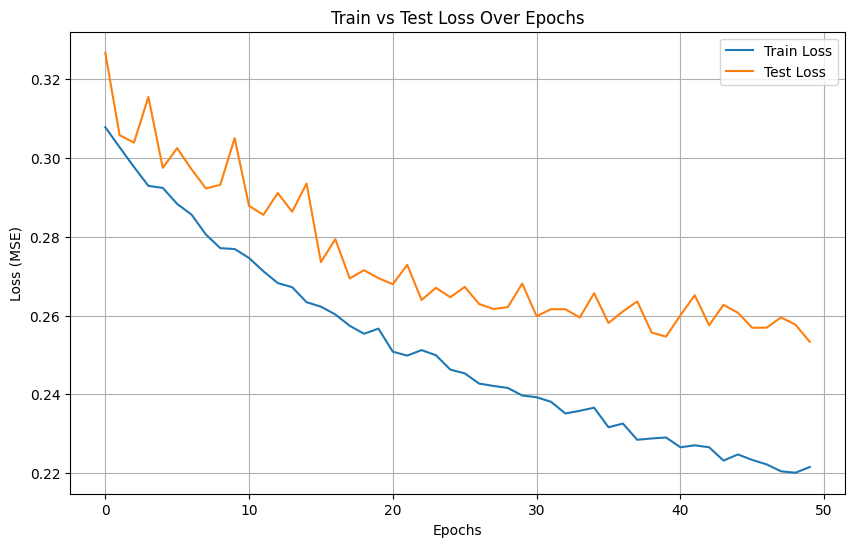

In [24]:
# Function to train the model and collect loss values for plotting
def train_regression_with_curves(train_loader, test_loader, model, criterion, optimizer, epochs=20):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Average loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on the test set after each epoch
        test_loss = evaluate_regression(test_loader, model)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

# Evaluate the model on the test set
def evaluate_regression(test_loader, model):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Train the model and collect train/test losses
train_losses, test_losses = train_regression_with_curves(train_loader, test_loader, pytorch_model, criterion, optimizer, epochs=50)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Keras Setup for Regression (Price Prediction)

## **Keras test loss: 0.2597**

* batch_size = 64
* Architecture:         
        model_keras = Sequential()
        model_keras.add(Dense(128, input_dim=X_train.shape[1], activation='tanh'))
        model_keras.add(Dense(64, activation='relu'))
        model_keras.add(Dense(32, activation='tanh'))
        model_keras.add(Dense(1))

* activation = tanh & relu
* learning_rate = 0.001
* epochs = 50


In [31]:
##################################
# Keras Setup for Regression
##################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam

In [82]:
# Define a simple neural network for regression using Keras
model_keras = Sequential()
model_keras.add(Dense(128, input_dim=X_train.shape[1], activation='tanh'))
model_keras.add(Dense(64, activation='relu'))
model_keras.add(Dense(32, activation='tanh'))
model_keras.add(Dense(1))  # Single output for regression


# Compile the Keras model
model_keras.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [83]:
# Keras model structure visualization
print("Keras Model Structure:")
model_keras.summary()


Keras Model Structure:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 128)               1152      
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11521 (45.00 KB)
Trainable params: 11521 (45.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
# Train the Keras model
history = model_keras.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
258/258 [==============================] - 1s 3ms/step - loss: 0.6124 - val_loss: 0.3951
Epoch 2/50
258/258 [==============================] - 1s 2ms/step - loss: 0.3640 - val_loss: 0.3523
Epoch 3/50
258/258 [==============================] - 1s 2ms/step - loss: 0.3368 - val_loss: 0.3369
Epoch 4/50
258/258 [==============================] - 1s 2ms/step - loss: 0.3198 - val_loss: 0.3337
Epoch 5/50
258/258 [==============================] - 1s 2ms/step - loss: 0.3113 - val_loss: 0.3174
Epoch 6/50
258/258 [==============================] - 1s 2ms/step - loss: 0.3052 - val_loss: 0.3087
Epoch 7/50
258/258 [==============================] - 1s 2ms/step - loss: 0.3015 - val_loss: 0.3092
Epoch 8/50
258/258 [==============================] - 1s 2ms/step - loss: 0.2982 - val_loss: 0.3164
Epoch 9/50
258/258 [==============================] - 1s 2ms/step - loss: 0.2938 - val_loss: 0.3172
Epoch 10/50
258/258 [==============================] - 1s 2ms/step - loss: 0.2929 - val_loss: 0.3007

In [85]:
# Evaluate the Keras model on a single batch
X_batch = X_train[:32]  # First 32 samples
y_batch = y_train[:32]
y_pred = model_keras.predict(X_batch)

# Display predicted and actual values in Keras
print(f'Predicted values (Keras): {y_pred.flatten()}')
print(f'Actual values (Keras): {y_batch.values.flatten()}')


1/1 [==============================] - 0s 59ms/step
Predicted values (Keras): [1.2803309 3.7158215 2.163614  0.9585116 1.2181013 2.8841162 1.5870751
 4.692988  1.5780079 2.890342  2.4705129 1.8892026 1.2034614 1.2599688
 2.2495618 1.6307592 1.9896274 1.6457154 1.8293906 1.3349024 0.9013094
 4.9726224 1.1360565 1.2193415 0.7437357 3.1722186 0.6909579 1.6387534
 2.223084  1.2623167 1.5356038 1.273222 ]
Actual values (Keras): [1.03    3.821   1.726   0.934   0.965   2.648   1.573   5.00001 1.398
 3.156   2.319   1.594   0.96    1.875   2.299   1.177   1.696   1.308
 1.574   0.941   0.727   5.00001 0.958   0.975   0.788   2.92    0.425
 1.875   2.182   0.875   1.463   1.374  ]


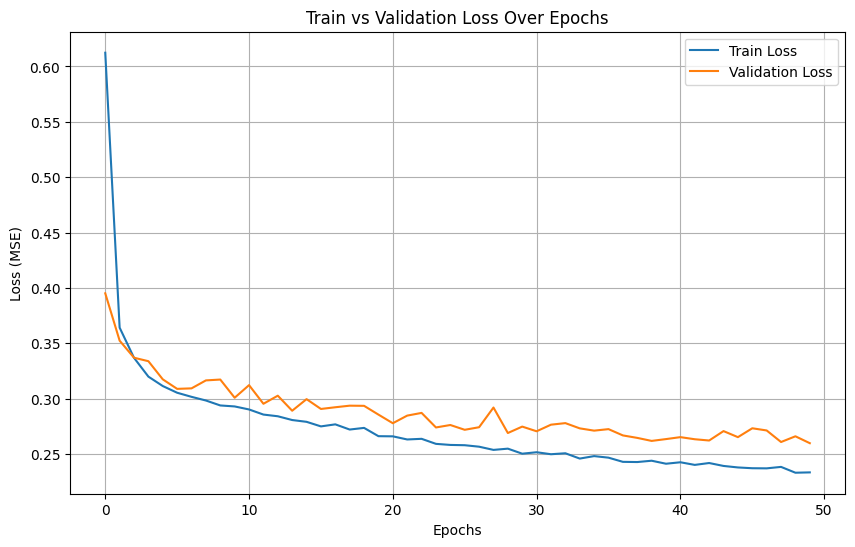

In [86]:
# Step 3: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
